# CLIP-Based Plant Compound to Skin Condition Matching

**Objective**: Use CLIP model to match plant compound descriptions with skin condition images

**Project**: Vision-Language Model (VLM) for predicting plant compound effects on human skin

**Data Sources**:
1. `herb2_final_clean.csv` - Plant compound information (text)
2. `skincon_preprocessed.csv` - Skin condition data with image filenames
3. Skin images: `/content/drive/MyDrive/Skincon/preprocessed/images/`

**Model**: OpenAI CLIP (clip-vit-base-patch32)

**Workflow**:
1. Load datasets and images
2. Encode plant descriptions using CLIP text encoder
3. Encode skin images using CLIP image encoder
4. Compute similarity scores (cosine similarity)
5. Rank and display top-5 plant compounds for each skin image

## 1. Import Required Libraries

In [1]:
# Core data processing libraries
import pandas as pd
import numpy as np
import os
from pathlib import Path
from typing import List, Tuple, Dict
import warnings
warnings.filterwarnings('ignore')

# Image processing
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Deep learning libraries
import torch
from transformers import CLIPProcessor, CLIPModel
from torch.nn.functional import cosine_similarity

# Progress bar
from tqdm.auto import tqdm

# Google Drive mounting (for Colab)
try:
    from google.colab import drive
    IN_COLAB = True
    print("Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("Running in local environment")

print(f"\nLibrary versions:")
print(f"  - Pandas: {pd.__version__}")
print(f"  - NumPy: {np.__version__}")
print(f"  - PyTorch: {torch.__version__}")
print(f"  - PIL: {Image.__version__ if hasattr(Image, '__version__') else 'installed'}")

# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\nUsing device: {device.upper()}")
if device == "cuda":
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Running in Google Colab

Library versions:
  - Pandas: 2.2.2
  - NumPy: 2.0.2
  - PyTorch: 2.8.0+cu126
  - PIL: 11.3.0

Using device: CPU


## 2. Configure Paths

In [2]:
from google.colab import drive
import os
from pathlib import Path

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Base directory
BASE_DIR = "/content/drive/MyDrive/499A Datasets"

# ✅ Correct dataset paths (based on your confirmation)
HERB_FILE = os.path.join(BASE_DIR, "Preprocessed", "herb2_final_clean.csv")
SKINCON_FILE = os.path.join(BASE_DIR, "Skincon", "preprocessed", "skincon_preprocessed.csv")
IMAGE_FOLDER = os.path.join(BASE_DIR, "Skincon", "preprocessed", "images")

# Create embedding and output directories
EMB_SAVE_DIR = os.path.join(BASE_DIR, "Skincon", "preprocessed", "clip_embeddings")
Path(EMB_SAVE_DIR).mkdir(parents=True, exist_ok=True)

OUTPUT_DIR = os.path.join(BASE_DIR, "clip_results")
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Verify all paths
print("✅ Final Path Configuration Check:")
print("=" * 80)
print(f"Herb CSV: {HERB_FILE} --> Exists: {os.path.exists(HERB_FILE)}")
print(f"Skincon CSV: {SKINCON_FILE} --> Exists: {os.path.exists(SKINCON_FILE)}")
print(f"Image Folder: {IMAGE_FOLDER} --> Exists: {os.path.exists(IMAGE_FOLDER)}")
print(f"Output Directory: {OUTPUT_DIR} --> Exists: {os.path.exists(OUTPUT_DIR)}")
print("=" * 80)


Mounted at /content/drive
✅ Final Path Configuration Check:
Herb CSV: /content/drive/MyDrive/499A Datasets/Preprocessed/herb2_final_clean.csv --> Exists: True
Skincon CSV: /content/drive/MyDrive/499A Datasets/Skincon/preprocessed/skincon_preprocessed.csv --> Exists: True
Image Folder: /content/drive/MyDrive/499A Datasets/Skincon/preprocessed/images --> Exists: True
Output Directory: /content/drive/MyDrive/499A Datasets/clip_results --> Exists: True


## 3. Load Datasets

In [3]:
# Load herb dataset
print("Loading plant compound dataset...")
try:
    herb_df = pd.read_csv(HERB_FILE, encoding='utf-8')
    print(f"✓ Loaded herb dataset: {herb_df.shape[0]:,} rows x {herb_df.shape[1]} columns")

    # Filter for SKIN-RELATED diseases ONLY
    if 'MeSH_disease_class' in herb_df.columns:
        print("\n🔍 Filtering for SKIN-RELATED diseases only...")
        herb_df = herb_df[
            herb_df['MeSH_disease_class'].str.contains('Skin and Connective Tissue Diseases',
                                                       case=False, na=False)
        ].copy()
        print(f"   After skin filter: {herb_df.shape[0]:,} rows (skin diseases only)")

except Exception as e:
    print(f"✗ Error loading herb dataset: {e}")
    herb_df = None

# Load skincon dataset
print("\nLoading skin condition dataset...")
try:
    skincon_df = pd.read_csv(SKINCON_FILE, encoding='utf-8')
    print(f"✓ Loaded skincon dataset: {skincon_df.shape[0]:,} rows x {skincon_df.shape[1]} columns")
except Exception as e:
    print(f"✗ Error loading skincon dataset: {e}")
    skincon_df = None

# Merge datasets on Disease_name == label (SKIN DISEASES ONLY)
if herb_df is not None and skincon_df is not None:
    print("\n" + "="*80)
    print("🌿 MERGING HERB & SKINCON DATASETS (SKIN DISEASES ONLY)")
    print("="*80)

    # Normalize for matching
    herb_df['disease_norm'] = herb_df['Disease_name'].str.lower().str.strip()
    skincon_df['label_norm'] = skincon_df['label'].str.lower().str.strip()

    # Show unique skin diseases available
    skin_diseases = herb_df['Disease_name'].nunique()
    print(f"📋 Unique SKIN diseases in herb dataset: {skin_diseases}")
    print(f"📋 Unique labels in skincon dataset: {skincon_df['label'].nunique()}")

    # Merge
    matched_df = skincon_df.merge(
        herb_df[['Disease_name', 'Disease_alias_name', 'Herb_en_name', 'Function',
                 'MeSH_disease_class', 'disease_norm']],
        left_on='label_norm',
        right_on='disease_norm',
        how='inner'
    )

    # Rename columns
    matched_df.rename(columns={
        'Herb_en_name': 'Herb_Name',
        'Function': 'Herb_Function',
        'Disease_name': 'Disease_Name',
        'Disease_alias_name': 'Disease_Alias_Name'
    }, inplace=True)

    # Clean up temp columns
    matched_df.drop(columns=['disease_norm', 'label_norm'], inplace=True)

    print(f"\n✅ Match Results (SKIN DISEASES ONLY):")
    print(f"   Original skincon rows: {skincon_df.shape[0]:,}")
    print(f"   Matched rows: {matched_df.shape[0]:,}")
    print(f"   Match rate: {(matched_df.shape[0] / skincon_df.shape[0] * 100):.1f}%")

    if matched_df.shape[0] > 0:
        # Save merged dataset
        matched_csv = os.path.join(BASE_DIR, "skincon_herb_matched_SKIN_ONLY.csv")
        matched_df.to_csv(matched_csv, index=False, encoding='utf-8')
        print(f"\n💾 Saved to: skincon_herb_matched_SKIN_ONLY.csv")

        # Show matched skin diseases
        matched_diseases = matched_df['Disease_Name'].nunique()
        print(f"\n🎯 Matched {matched_diseases} unique SKIN diseases")
        print(f"   Examples: {', '.join(matched_df['Disease_Name'].unique()[:5])}")

        # Show new columns
        print(f"\n📋 New Columns:")
        print(f"   • Herb_Name: {matched_df['Herb_Name'].notna().sum():,} values")
        print(f"   • Herb_Function: {matched_df['Herb_Function'].notna().sum():,} values")
        print(f"   • Disease_Name: {matched_df['Disease_Name'].notna().sum():,} values")
        print(f"   • Disease_Alias_Name: {matched_df['Disease_Alias_Name'].notna().sum():,} values")
        print(f"   • MeSH_disease_class: All contain 'Skin and Connective Tissue Diseases'")

        # Use matched data going forward
        skincon_df = matched_df.copy()
    else:
        print("\n⚠️ WARNING: No matches found! Check disease name alignment.")
        skincon_df = None

else:
    print("\n✗ Failed to load datasets")

Loading plant compound dataset...
✓ Loaded herb dataset: 44,595 rows x 23 columns

🔍 Filtering for SKIN-RELATED diseases only...
   After skin filter: 1,707 rows (skin diseases only)

Loading skin condition dataset...
✓ Loaded skincon dataset: 16,518 rows x 62 columns

🌿 MERGING HERB & SKINCON DATASETS (SKIN DISEASES ONLY)
📋 Unique SKIN diseases in herb dataset: 1707
📋 Unique labels in skincon dataset: 114

✅ Match Results (SKIN DISEASES ONLY):
   Original skincon rows: 16,518
   Matched rows: 6,337
   Match rate: 38.4%

💾 Saved to: skincon_herb_matched_SKIN_ONLY.csv

🎯 Matched 36 unique SKIN diseases
   Examples: Psoriasis, Granuloma Annulare, Hidradenitis, Acne Vulgaris, Xeroderma Pigmentosum

📋 New Columns:
   • Herb_Name: 5,193 values
   • Herb_Function: 3,826 values
   • Disease_Name: 6,337 values
   • Disease_Alias_Name: 6,284 values
   • MeSH_disease_class: All contain 'Skin and Connective Tissue Diseases'


## 4. Explore Datasets

In [4]:
if herb_df is not None:
    print("HERB DATASET PREVIEW")
    print("=" * 80)
    display(herb_df.head())

HERB DATASET PREVIEW


,Herb_id,Herb_en_name,Herb_latin_name,Properties,Meridians,UsePart,Function,Indication,Toxicity,Ingredient_id,...,OB_score,CAS_id,PubChem_id,Disease_id,Disease_name,Disease_alias_name,UMLS_disease_type,MeSH_disease_class,text_for_vlm,disease_norm
18,HERB000020,Iran Speedwell,Veronica Persica,NaN,NaN,Whole herb,"To dispel wind and eliminate damp, strengthen ...","Wind-damp impediment pain, kidney vacuity lumb...",NaN,HBIN000022,...,NaN,128722-90-7,NaN,HBDIS000019,Acantholysis,Acantholysis,Pathologic Function,Skin and Connective Tissue Diseases; Pathologi...,Iran Speedwell | Veronica Persica | To dispel ...,acantholysis
19,HERB000021,Fomes Officinalis Sporocarp,Fomes Officinalis,Sweet; Bitter; Warm,NaN,Sporocarp,"To relieve cough and calm asthma, dispel wind ...","Cough, asthma, chronic rheumatic arthritis, sw...",NaN,HBIN000023,...,NaN,128722-92-9,NaN,HBDIS000020,Acanthosis Nigricans,Acanthosis Nigricans; Keratosis Nigricans; Dar...,Disease or Syndrome,Skin and Connective Tissue Diseases,Fomes Officinalis Sporocarp | Fomes Officinali...,acanthosis nigricans
29,HERB000031,Ajowan,Trachyspermum Ammi,NaN,NaN,Fruit,"To dissipate cold and relieve pain, resolve to...","Cold pain in stomach duct and abdomen, indiges...",NaN,HBIN000035,...,24.871,104387-15-7,128558.0,HBDIS000030,Acne Vulgaris,Acne; Acne Vulgaris,Disease or Syndrome,Skin and Connective Tissue Diseases,Ajowan | Trachyspermum Ammi | To dissipate col...,acne vulgaris
30,HERB000032,Fructus Trachyspermi Ammi,Fructus Trachyspermi Ammi,Acrid; Bitter; Warm,NaN,Fruit,Dissipate cold and relieve paindrain dampness ...,Abdominal cold pain; Indigestion; Nausea and v...,NaN,HBIN000036,...,44.058,10482-53-8,5352710.0,HBDIS000031,Acne Keloid,Acne Keloid,Disease or Syndrome,Skin and Connective Tissue Diseases,Fructus Trachyspermi Ammi | Fructus Trachysper...,acne keloid
33,HERB000035,Low Rhubarb,Rheum Nanum,NaN,NaN,NaN,NaN,NaN,NaN,HBIN000040,...,NaN,NaN,10906642.0,HBDIS000034,Acrodermatitis,Acrodermatitis; Gianotti-Crosti Syndrome,Disease or Syndrome,Skin and Connective Tissue Diseases; Congenita...,Low Rhubarb | Rheum Nanum | Adinoside b | C21H...,acrodermatitis


In [ ]:
if skincon_df is not None:
    print("SKINCON DATASET PREVIEW")
    print("=" * 80)
    display(skincon_df.head())

SKINCON DATASET PREVIEW


,md5hash,fitzpatrick_scale,fitzpatrick_centaur,label,nine_partition_label,three_partition_label,qc,url,url_alphanum,image_path,...,Poikiloderma,Salmon,Wheal,Acuminate,Burrow,Gray,Pigmented,Cyst,Do not consider this image,text_prompt
0,5e82a45bc5d78bd24ae9202d194423f8,3,3,drug induced pigmentary changes,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicmminoc...,/content/drive/MyDrive/499A Datasets/Skincon/p...,...,0,0,0,0,0,0,0,0,0,Image of human skin showing drug induced pigme...
1,fa2911a9b13b6f8af79cb700937cc14f,1,1,photodermatoses,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicpphoto...,/content/drive/MyDrive/499A Datasets/Skincon/p...,...,0,0,0,0,0,0,0,0,0,Image of human skin showing photodermatoses wi...
2,d2bac3c9e4499032ca8e9b07c7d3bc40,2,3,dermatofibroma,benign dermal,benign,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicdderma...,/content/drive/MyDrive/499A Datasets/Skincon/p...,...,0,0,0,0,0,0,0,0,0,Image of human skin showing dermatofibroma
3,0a94359e7eaacd7178e06b2823777789,1,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...,/content/drive/MyDrive/499A Datasets/Skincon/p...,...,0,0,0,0,0,0,0,0,0,Image of human skin showing psoriasis
4,a39ec3b1f22c08a421fa20535e037bba,1,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...,/content/drive/MyDrive/499A Datasets/Skincon/p...,...,0,0,0,0,0,0,0,0,0,Image of human skin showing psoriasis


In [5]:
# Preview matched dataset with herb information
if 'Herb_Name' in skincon_df.columns:
    print("="*80)
    print("🌿 MATCHED DATASET - Skin Conditions with Herb Info")
    print("="*80)

    display_cols = ['label', 'Herb_Name', 'Herb_Function', 'Disease_Name', 'Disease_Alias_Name']
    available_cols = [c for c in display_cols if c in skincon_df.columns]

    display(skincon_df[available_cols].head(10))

🌿 MATCHED DATASET - Skin Conditions with Herb Info


,label,Herb_Name,Herb_Function,Disease_Name,Disease_Alias_Name
0,psoriasis,Herb Celosiae Cristatae,Clear heat and cool the bloodresolve toxins,Psoriasis,"Psoriasis, Unspecified; Psoriasis; Pustulosis ..."
1,psoriasis,Herb Celosiae Cristatae,Clear heat and cool the bloodresolve toxins,Psoriasis,"Psoriasis, Unspecified; Psoriasis; Pustulosis ..."
2,granuloma annulare,Woodland Sunflower,NaN,Granuloma Annulare,Granuloma Annulare
3,hidradenitis,Antelope Horn,Treatment of high fever with convulsion and im...,Hidradenitis,Hidradenitis; Neutrophilic Eccrine Hidradenitis
4,acne vulgaris,Ajowan,"To dissipate cold and relieve pain, resolve to...",Acne Vulgaris,Acne; Acne Vulgaris
5,xeroderma pigmentosum,Carp Gall,"To clear heat and brighten eyes, dissipate scr...",Xeroderma Pigmentosum,Xeroderma Pigmentosum Variant Type; Xeroderma ...
6,actinic keratosis,Beeswax,"Treatment of ulcer difficulty to heal, wounds,...",Actinic Keratosis,"Keratosis, Actinic; Actinic Keratosis; Solar K..."
7,scleroderma,Parisshape Loosestrife,"To dispel wind and eliminate damp, quicken blo...",Scleroderma,Dermatosclerosis; Morphea; Systemic Scleroderm...
8,hidradenitis,Antelope Horn,Treatment of high fever with convulsion and im...,Hidradenitis,Hidradenitis; Neutrophilic Eccrine Hidradenitis
9,folliculitis,Golden Lycoris,"To moisten lung and relieve cough, resolve tox...",Folliculitis,Folliculitis


## 5. Prepare Text Descriptions for Plant Compounds

In [6]:
def create_herb_description(row):
    """
    Create enhanced description using matched herb information.
    """
    parts = []

    # Use matched Herb_Name
    if 'Herb_Name' in row and pd.notna(row['Herb_Name']):
        parts.append(f"Herb: {row['Herb_Name']}")

    # Use matched Herb_Function
    if 'Herb_Function' in row and pd.notna(row['Herb_Function']):
        func = str(row['Herb_Function'])[:200]
        parts.append(f"Function: {func}")

    # Add disease treatment info
    if 'Disease_Name' in row and pd.notna(row['Disease_Name']):
        parts.append(f"Treats: {row['Disease_Name']}")

    # Add aliases
    if 'Disease_Alias_Name' in row and pd.notna(row['Disease_Alias_Name']):
        alias = str(row['Disease_Alias_Name'])[:100]
        parts.append(f"Also: {alias}")

    return ". ".join(parts) if parts else "Medicinal herb for skin treatment"

if skincon_df is not None and 'Herb_Name' in skincon_df.columns:
    print("Creating herb-based descriptions...")
    skincon_df['herb_description'] = skincon_df.apply(create_herb_description, axis=1)

    print(f"✓ Created {len(skincon_df):,} descriptions")
    print(f"\n📝 Samples:")
    for i, desc in enumerate(skincon_df['herb_description'].head(3), 1):
        print(f"\n{i}. {desc[:180]}..." if len(desc) > 180 else f"\n{i}. {desc}")

Creating herb-based descriptions...
✓ Created 6,337 descriptions

📝 Samples:

1. Herb: Herb Celosiae Cristatae. Function: Clear heat and cool the bloodresolve toxins. Treats: Psoriasis. Also: Psoriasis, Unspecified; Psoriasis; Pustulosis of Palm And Sole; Pustu...

2. Herb: Herb Celosiae Cristatae. Function: Clear heat and cool the bloodresolve toxins. Treats: Psoriasis. Also: Psoriasis, Unspecified; Psoriasis; Pustulosis of Palm And Sole; Pustu...

3. Herb: Woodland Sunflower. Treats: Granuloma Annulare. Also: Granuloma Annulare


## 6. Verify Image Files

In [7]:
import glob

if skincon_df is not None and os.path.exists(IMAGE_FOLDER):
    print("Verifying image files (including subfolders)...")
    print("=" * 80)

    # Try to find image filename column
    image_col = None
    for col in ['image_filename', 'filename', 'image_name', 'file', 'image']:
        if col in skincon_df.columns:
            image_col = col
            break

    if image_col is None:
        print(f"Could not find image filename column.")
        print(f"  Available columns: {', '.join(skincon_df.columns.tolist())}")
    else:
        print(f"Using image filename column: '{image_col}'")

        # Create a dictionary mapping filenames → full paths (recursive search)
        print("\nScanning all image files recursively...")
        image_paths = glob.glob(os.path.join(IMAGE_FOLDER, "**", "*.*"), recursive=True)
        image_map = {os.path.basename(p): p for p in image_paths}

        print(f"  Found {len(image_paths):,} total image files in subfolders.\n")

        # Map filenames from dataset to full paths
        skincon_df['image_path'] = skincon_df[image_col].apply(
            lambda x: image_map.get(str(x).strip()) if pd.notna(x) else None
        )

        # Check which images exist
        skincon_df['image_exists'] = skincon_df['image_path'].notnull()
        existing_images = skincon_df['image_exists'].sum()
        total_images = len(skincon_df)

        print(f"Found {existing_images:,} / {total_images:,} images")
        print(f"  Missing: {total_images - existing_images:,} images")

        if existing_images > 0:
            skincon_df = skincon_df[skincon_df['image_exists']].copy()
            print(f"\n✅ Dataset filtered to {len(skincon_df):,} rows with existing images")
        else:
            print(f"\n❌ No matching images found in any subfolders under {IMAGE_FOLDER}")
else:
    if skincon_df is None:
        print("Skincon dataset not loaded")
    else:
        print(f"Image folder not found: {IMAGE_FOLDER}")


Verifying image files (including subfolders)...
Using image filename column: 'filename'

Scanning all image files recursively...
  Found 16,518 total image files in subfolders.

Found 6,337 / 6,337 images
  Missing: 0 images

✅ Dataset filtered to 6,337 rows with existing images


## 7. Load CLIP Model

In [8]:
MODEL_NAME = "openai/clip-vit-base-patch32"

print(f"Loading CLIP model: {MODEL_NAME}")
print("=" * 80)

try:
    model = CLIPModel.from_pretrained(MODEL_NAME)
    processor = CLIPProcessor.from_pretrained(MODEL_NAME)

    model = model.to(device)
    model.eval()

    print(f"CLIP model loaded successfully on {device.upper()}")
    print(f"\nModel details:")
    print(f"  - Vision encoder: {model.config.vision_config.hidden_size}-dim embeddings")
    print(f"  - Text encoder: {model.config.text_config.hidden_size}-dim embeddings")

except Exception as e:
    print(f"Error loading CLIP model: {e}")
    model = None
    processor = None

Loading CLIP model: openai/clip-vit-base-patch32


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIP model loaded successfully on CPU

Model details:
  - Vision encoder: 768-dim embeddings
  - Text encoder: 512-dim embeddings


## 8. Encode Plant Compound Descriptions

In [9]:
def encode_texts(texts: List[str], batch_size: int = 32) -> torch.Tensor:
    """
    Encode text descriptions into CLIP embeddings.
    """
    all_embeddings = []

    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Encoding texts"):
            batch_texts = texts[i:i+batch_size]

            inputs = processor(text=batch_texts, return_tensors="pt",
                             padding=True, truncation=True, max_length=77)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            text_embeddings = model.get_text_features(**inputs)
            text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

            all_embeddings.append(text_embeddings.cpu())

    return torch.cat(all_embeddings, dim=0)

# Encode herb descriptions (SKIN diseases only)
if skincon_df is not None and model is not None and 'herb_description' in skincon_df.columns:
    print("Encoding herb-based descriptions with CLIP (SKIN diseases)...")
    print("="*80)

    herb_texts = skincon_df['herb_description'].tolist()
    herb_embeddings = encode_texts(herb_texts, batch_size=32)

    print(f"\n✓ Encoded {len(herb_embeddings):,} herb descriptions")
    print(f"  Embedding shape: {herb_embeddings.shape}")
    print(f"  All descriptions are for SKIN-related treatments")
else:
    print("✗ Cannot encode: missing herb_description column or model not loaded")
    herb_embeddings = None

Encoding herb-based descriptions with CLIP (SKIN diseases)...


Encoding texts:   0%|          | 0/199 [00:00<?, ?it/s]


✓ Encoded 6,337 herb descriptions
  Embedding shape: torch.Size([6337, 512])
  All descriptions are for SKIN-related treatments


In [10]:
import os

dataset_dir = "/content/drive/MyDrive/499A Datasets/Skincon/preprocessed/images"

# Verify folder existence and count files
print("Folder exists:", os.path.exists(dataset_dir))
print("Total files:", len(os.listdir(dataset_dir)))

# Show a few sample file names
print("First few files:", os.listdir(dataset_dir)[:5])


Folder exists: True
Total files: 114
First few files: ['drug_induced_pigmentary_changes', 'photodermatoses', 'dermatofibroma', 'psoriasis', 'kaposi_sarcoma']


In [11]:
import os
from sklearn.model_selection import train_test_split

dataset_dir = "/content/drive/MyDrive/499A Datasets/Skincon/preprocessed/images"

# Recursively find all image files inside all subfolders
all_images = []
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            all_images.append(os.path.join(root, file))

print(f"✅ Found {len(all_images)} image files in total.")

# Split into 70% train and 30% test
train_imgs, test_imgs = train_test_split(all_images, test_size=0.3, random_state=42)

print(f"Train images: {len(train_imgs)}")
print(f"Test images: {len(test_imgs)}")


✅ Found 16518 image files in total.
Train images: 11562
Test images: 4956


## 9. Encode Skin Condition Images

In [12]:
def encode_images(image_paths: List[str], batch_size: int = 16) -> Tuple[torch.Tensor, List[int]]:
    """
    Encode images into CLIP embeddings.
    """
    all_embeddings = []
    valid_indices = []

    with torch.no_grad():
        for i in tqdm(range(0, len(image_paths), batch_size), desc="Encoding images"):
            batch_paths = image_paths[i:i+batch_size]
            batch_images = []
            batch_valid_idx = []

            for idx, path in enumerate(batch_paths):
                try:
                    if path and os.path.exists(path):
                        image = Image.open(path).convert('RGB')
                        batch_images.append(image)
                        batch_valid_idx.append(i + idx)
                except Exception as e:
                    print(f"Warning: Could not load image {path}: {e}")
                    continue

            if batch_images:
                inputs = processor(images=batch_images, return_tensors="pt", padding=True)
                inputs = {k: v.to(device) for k, v in inputs.items()}

                image_embeddings = model.get_image_features(**inputs)
                image_embeddings = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)

                all_embeddings.append(image_embeddings.cpu())
                valid_indices.extend(batch_valid_idx)

    if all_embeddings:
        return torch.cat(all_embeddings, dim=0), valid_indices
    else:
        return torch.empty(0), []

if skincon_df is not None and model is not None and 'image_path' in skincon_df.columns:
    print("Encoding skin condition images with CLIP...")
    print("=" * 80)

    image_paths = skincon_df['image_path'].tolist()
    image_embeddings, valid_indices = encode_images(image_paths, batch_size=16)

    skincon_df = skincon_df.iloc[valid_indices].reset_index(drop=True)

    print(f"\nEncoded {len(image_embeddings):,} skin images")
    print(f"  Embedding shape: {image_embeddings.shape}")
else:
    print("Cannot encode images: skincon_df, model, or image_path not available")
    image_embeddings = None

Encoding skin condition images with CLIP...


Encoding images:   0%|          | 0/397 [00:00<?, ?it/s]


Encoded 6,337 skin images
  Embedding shape: torch.Size([6337, 512])


## 10. Compute Similarity Scores

In [13]:
if image_embeddings is not None and herb_embeddings is not None:
    print("Computing similarity scores...")
    print("=" * 80)

    similarity_matrix = image_embeddings @ herb_embeddings.T

    print(f"Computed similarity matrix")
    print(f"  Shape: {similarity_matrix.shape} (images x plant compounds)")
    print(f"  Min similarity: {similarity_matrix.min():.4f}")
    print(f"  Max similarity: {similarity_matrix.max():.4f}")
    print(f"  Mean similarity: {similarity_matrix.mean():.4f}")
else:
    print("Cannot compute similarity: embeddings not available")
    similarity_matrix = None

Computing similarity scores...
Computed similarity matrix
  Shape: torch.Size([6337, 6337]) (images x plant compounds)
  Min similarity: 0.1094
  Max similarity: 0.3586
  Mean similarity: 0.2601


## 11. Get Top-5 Plant Compounds for Each Image

In [14]:
if similarity_matrix is not None:
    print("Finding top-5 plant compounds for each image...")
    print("=" * 80)

    top_k = 5
    top_scores, top_indices = torch.topk(similarity_matrix, k=top_k, dim=1)

    print(f"Found top-{top_k} matches for {len(top_scores):,} images")
else:
    print("Cannot find top matches: similarity matrix not available")
    top_scores = None
    top_indices = None

Finding top-5 plant compounds for each image...
Found top-5 matches for 6,337 images


## 12. Display Results

In [15]:
if top_scores is not None and top_indices is not None and skincon_df is not None:
    print("="*80)
    print("🌿 TOP-5 HERB MATCHES FOR SKIN CONDITIONS (SKIN DISEASES ONLY)")
    print("="*80)

    num_to_display = min(5, len(skincon_df))

    for img_idx in range(num_to_display):
        row = skincon_df.iloc[img_idx]
        print(f"\n{'='*80}")
        print(f"🖼️  Image #{img_idx + 1}: {row['label']}")
        print(f"📁 File: {os.path.basename(row['image_path'])}")
        if 'Disease_Name' in row:
            print(f"🏥 Skin Disease: {row['Disease_Name']}")
        print(f"{'='*80}")

        for rank, (score, herb_idx) in enumerate(zip(top_scores[img_idx], top_indices[img_idx]), 1):
            matched_row = skincon_df.iloc[herb_idx.item()]

            herb_name = matched_row.get('Herb_Name', 'Unknown')
            herb_func = matched_row.get('Herb_Function', 'N/A')
            disease = matched_row.get('Disease_Name', 'N/A')

            print(f"\n  {rank}. 🌿 {herb_name}")
            print(f"     📊 Similarity: {score.item():.4f}")
            print(f"     💊 Function: {str(herb_func)[:100]}{'...' if len(str(herb_func)) > 100 else ''}")
            print(f"     🎯 Treats: {disease}")

    if len(skincon_df) > num_to_display:
        print(f"\n... and {len(skincon_df) - num_to_display} more skin condition images")
else:
    print("✗ Cannot display results - missing required data")

🌿 TOP-5 HERB MATCHES FOR SKIN CONDITIONS (SKIN DISEASES ONLY)

🖼️  Image #1: psoriasis
📁 File: 0a94359e7eaacd7178e06b2823777789.jpg
🏥 Skin Disease: Psoriasis

  1. 🌿 Areca Peel; Areca Catechu L.
     📊 Similarity: 0.3105
     💊 Function: Move qi and loosen the centermove water and disperse swelling
     🎯 Treats: Erythema Multiforme

  2. 🌿 Areca Peel; Areca Catechu L.
     📊 Similarity: 0.3105
     💊 Function: Move qi and loosen the centermove water and disperse swelling
     🎯 Treats: Erythema Multiforme

  3. 🌿 Areca Peel; Areca Catechu L.
     📊 Similarity: 0.3105
     💊 Function: Move qi and loosen the centermove water and disperse swelling
     🎯 Treats: Erythema Multiforme

  4. 🌿 Areca Peel; Areca Catechu L.
     📊 Similarity: 0.3105
     💊 Function: Move qi and loosen the centermove water and disperse swelling
     🎯 Treats: Erythema Multiforme

  5. 🌿 Areca Peel; Areca Catechu L.
     📊 Similarity: 0.3105
     💊 Function: Move qi and loosen the centermove water and disperse s

## 13. Save Results to CSV

In [16]:
if top_scores is not None and top_indices is not None and skincon_df is not None:
    print("Saving enhanced results to CSV (SKIN diseases only)...")
    print("="*80)

    results = []

    for img_idx in range(len(skincon_df)):
        img_row = skincon_df.iloc[img_idx]

        for rank, (score, herb_idx) in enumerate(zip(top_scores[img_idx], top_indices[img_idx]), 1):
            match_row = skincon_df.iloc[herb_idx.item()]

            results.append({
                'image_filename': os.path.basename(img_row['image_path']),
                'skin_condition_label': img_row['label'],
                'rank': rank,
                'similarity_score': score.item(),
                'herb_name': match_row.get('Herb_Name', 'Unknown'),
                'herb_function': match_row.get('Herb_Function', ''),
                'disease_name': match_row.get('Disease_Name', ''),
                'disease_alias': match_row.get('Disease_Alias_Name', ''),
                'full_description': match_row.get('herb_description', ''),
                'disease_class': 'Skin and Connective Tissue Diseases'
            })

    results_df = pd.DataFrame(results)
    output_file = os.path.join(OUTPUT_DIR, 'skincon_herb_clip_results_SKIN_ONLY.csv')
    results_df.to_csv(output_file, index=False, encoding='utf-8')

    print(f"✓ Saved to: skincon_herb_clip_results_SKIN_ONLY.csv")
    print(f"  Total predictions: {len(results_df):,} rows")
    print(f"  Skin images processed: {len(skincon_df):,}")
    print(f"  Top-K per image: 5")
    print(f"  All treatments are for SKIN diseases ONLY")
else:
    print("✗ Cannot save results - missing required data")

Saving enhanced results to CSV (SKIN diseases only)...
✓ Saved to: skincon_herb_clip_results_SKIN_ONLY.csv
  Total predictions: 31,685 rows
  Skin images processed: 6,337
  Top-K per image: 5
  All treatments are for SKIN diseases ONLY


## 14. Visualize Sample Prediction

Creating visualization for herb-skin match (SKIN disease)...
✓ Visualization saved: /content/drive/MyDrive/499A Datasets/clip_results/skin_herb_match_0.png


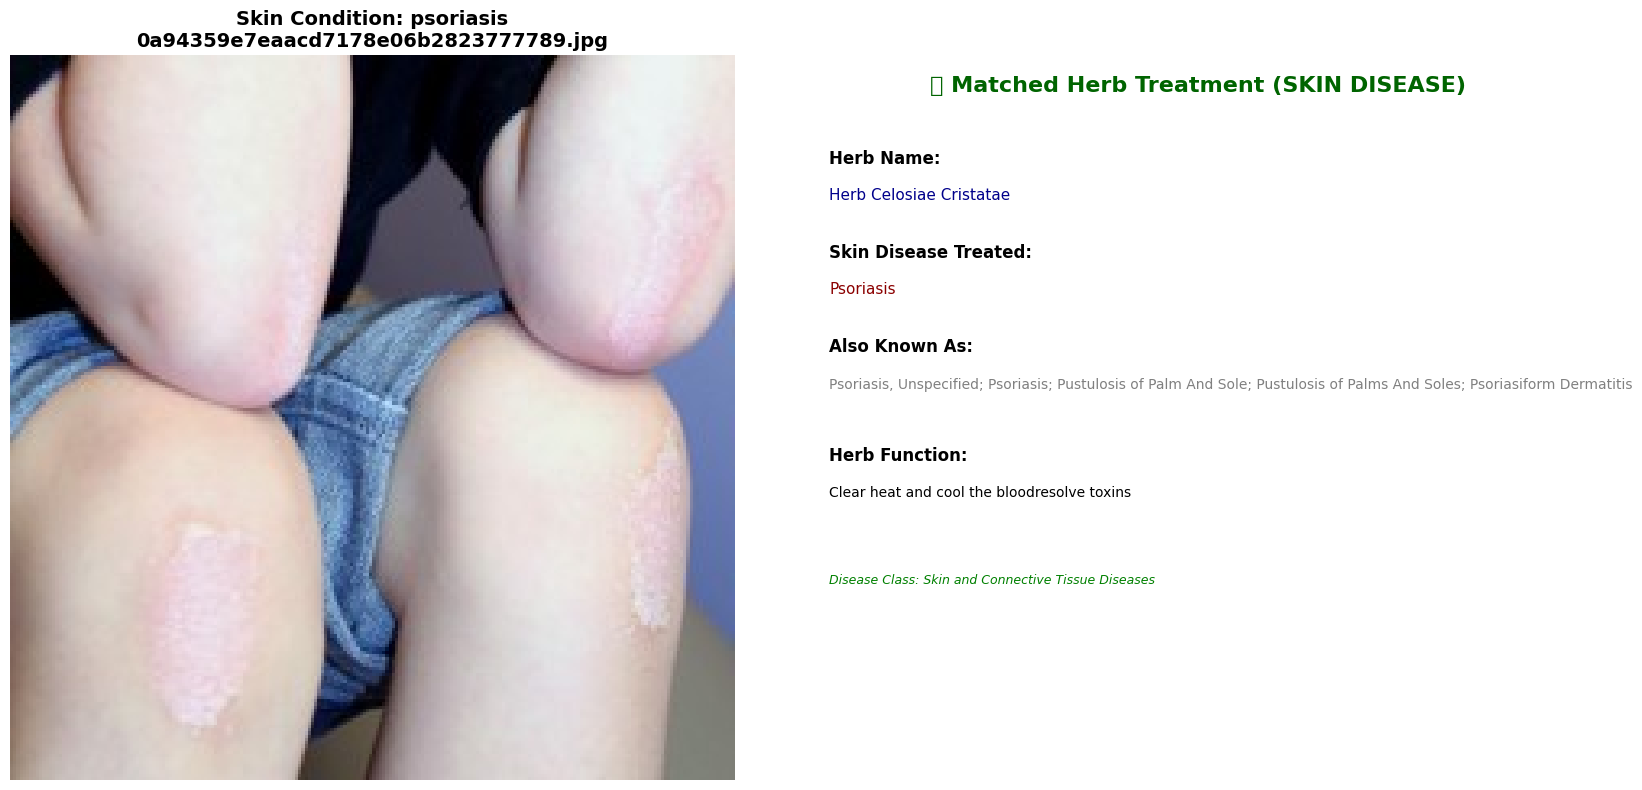

In [17]:
def visualize_prediction(image_idx: int):
    """
    Visualize skin image with matched herb info (SKIN diseases only).
    """
    if image_idx >= len(skincon_df):
        print(f"✗ Invalid index: {image_idx}")
        return

    row = skincon_df.iloc[image_idx]

    try:
        image = Image.open(row['image_path']).convert('RGB')
    except Exception as e:
        print(f"✗ Error loading image: {e}")
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

    # Display image
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title(f"Skin Condition: {row['label']}\n{os.path.basename(row['image_path'])}",
                 fontsize=14, fontweight='bold')

    # Display herb information
    ax2.axis('off')
    y = 0.95

    ax2.text(0.5, y, f"🌿 Matched Herb Treatment (SKIN DISEASE)",
            fontsize=16, fontweight='bold', ha='center', color='darkgreen')
    y -= 0.10

    ax2.text(0.05, y, f"Herb Name:", fontsize=12, fontweight='bold')
    y -= 0.05
    ax2.text(0.05, y, row.get('Herb_Name', 'Unknown'), fontsize=11, color='darkblue')
    y -= 0.08

    ax2.text(0.05, y, f"Skin Disease Treated:", fontsize=12, fontweight='bold')
    y -= 0.05
    ax2.text(0.05, y, row.get('Disease_Name', 'Unknown'), fontsize=11, color='darkred')
    y -= 0.08

    if pd.notna(row.get('Disease_Alias_Name')):
        ax2.text(0.05, y, f"Also Known As:", fontsize=12, fontweight='bold')
        y -= 0.05
        aliases = str(row['Disease_Alias_Name'])[:120]
        ax2.text(0.05, y, aliases, fontsize=10, color='gray', wrap=True)
        y -= 0.10

    ax2.text(0.05, y, f"Herb Function:", fontsize=12, fontweight='bold')
    y -= 0.05
    function = str(row.get('Herb_Function', 'Not available'))[:250]
    ax2.text(0.05, y, function, fontsize=10, wrap=True, color='black')
    y -= 0.12

    ax2.text(0.05, y, f"Disease Class: Skin and Connective Tissue Diseases",
            fontsize=9, style='italic', color='green')

    plt.tight_layout()

    output_path = os.path.join(OUTPUT_DIR, f'skin_herb_match_{image_idx}.png')
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"✓ Visualization saved: {output_path}")
    plt.show()

# Visualize first matched result
if skincon_df is not None and len(skincon_df) > 0:
    print("Creating visualization for herb-skin match (SKIN disease)...")
    print("="*80)
    visualize_prediction(0)
else:
    print("✗ Cannot visualize - no matched data available")

## 15. Summary Statistics

In [18]:
if similarity_matrix is not None and top_scores is not None:
    print("="*80)
    print("📊 SUMMARY STATISTICS (SKIN DISEASES ONLY)")
    print("="*80)

    print(f"\n📋 Datasets:")
    print(f"  - Plant compounds (SKIN diseases): {len(skincon_df):,}")
    print(f"  - Skin images processed: {len(skincon_df):,}")
    print(f"  - Total similarity computations: {len(skincon_df) * len(skincon_df):,}")
    print(f"  - Disease filter: 'Skin and Connective Tissue Diseases' ONLY")

    print(f"\n📈 Similarity Scores:")
    print(f"  - Overall mean: {similarity_matrix.mean():.4f}")
    print(f"  - Overall std: {similarity_matrix.std():.4f}")
    print(f"  - Overall min: {similarity_matrix.min():.4f}")
    print(f"  - Overall max: {similarity_matrix.max():.4f}")

    print(f"\n🎯 Top-5 Matches:")
    print(f"  - Mean similarity of top-1 matches: {top_scores[:, 0].mean():.4f}")
    print(f"  - Mean similarity of top-5 matches: {top_scores[:, 4].mean():.4f}")
    print(f"  - Best match overall: {top_scores.max():.4f}")

    if 'Disease_Name' in skincon_df.columns:
        unique_diseases = skincon_df['Disease_Name'].nunique()
        print(f"\n🏥 Disease Statistics:")
        print(f"  - Unique SKIN diseases matched: {unique_diseases}")
        print(f"  - Top 5 diseases: {', '.join(skincon_df['Disease_Name'].value_counts().head().index.tolist())}")

    print("\n" + "="*80)
    print("✅ CLIP MATCHING PIPELINE COMPLETED SUCCESSFULLY!")
    print("🌿 All results are for SKIN-RELATED diseases ONLY")
    print("="*80)
else:
    print("✗ Cannot display summary - results not available")

📊 SUMMARY STATISTICS (SKIN DISEASES ONLY)

📋 Datasets:
  - Plant compounds (SKIN diseases): 6,337
  - Skin images processed: 6,337
  - Total similarity computations: 40,157,569
  - Disease filter: 'Skin and Connective Tissue Diseases' ONLY

📈 Similarity Scores:
  - Overall mean: 0.2601
  - Overall std: 0.0304
  - Overall min: 0.1094
  - Overall max: 0.3586

🎯 Top-5 Matches:
  - Mean similarity of top-1 matches: 0.3117
  - Mean similarity of top-5 matches: 0.3117
  - Best match overall: 0.3586

🏥 Disease Statistics:
  - Unique SKIN diseases matched: 36
  - Top 5 diseases: Psoriasis, Lichen Planus, Lupus Erythematosus, Folliculitis, Acne Vulgaris

✅ CLIP MATCHING PIPELINE COMPLETED SUCCESSFULLY!
🌿 All results are for SKIN-RELATED diseases ONLY


---

## Notes

### For Google Colab Users:
1. **First time**: You'll need to authorize Google Drive access when mounting
2. **Folder path**: The folder ID from the URL won't directly work - you need to navigate by folder name
3. **Shared folders**: If the folder is shared with you (not in "My Drive"), it may be under "Shared with me" and require a different path

### For Local Users:
1. Download the CSV files from Google Drive manually
2. Place them in your local project directory matching the structure:
   - `data/preprocessed/herb2_final_clean.csv`
   - `data/skincon/preprocessed/skincon_preprocessed.csv`
3. Update `DRIVE_BASE` in cell 2 to point to your local data directory

### Alternative: Google Drive API
For programmatic access without Colab, you can use the Google Drive API with PyDrive or gdown libraries.